Text(0, 0.5, 'Y')

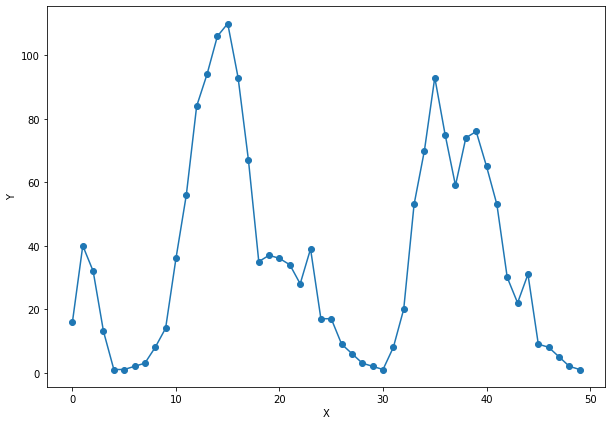

In [2]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt

rides = pd.read_csv('hour.csv')
rides.head()
counts = rides['cnt'][:50]
x = np.arange(len(counts))
y = np.array(counts)
plt.figure(figsize = (10, 7))
plt.plot(x, y, '-o')
plt.xlabel('X')
plt.ylabel('Y')

In [4]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for field in dummy_fields:
    # one-hot encoding
    dummies = pd.get_dummies(rides[field], prefix = field, drop_first = False)
    rides = pd.concat([rides, dummies], axis = 1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis = 1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
# normalization
quant_features = ['cnt', 'temp', 'hum', 'windspeed']
scaled_features = {}
for feature in quant_features:
    mean, std = data[feature].mean(), data[feature].std()
    scaled_features[feature] = [mean, std]
    data.loc[:, feature] = (data[feature] - mean) / std

# split data
test_data = data[-21 * 24:]
train_data = data[:-21 * 24]

targets = ['cnt', 'casual', 'registered']
train_X, train_Y = train_data.drop(targets, axis = 1), train_data[targets]
test_X, test_Y = test_data.drop(targets, axis = 1), test_data[targets]

# Dataframe to Numpy
X = train_X.values
Y = train_Y['cnt'].values.astype(float)
Y = np.reshape(Y, [len(Y), 1])


0 0.8894435
100 0.2731616
200 0.21710274
300 0.151847
400 0.10961365
500 0.09150733
600 0.084326714
700 0.07923118
800 0.07335418
900 0.06891508


Text(0, 0.5, 'MSE')

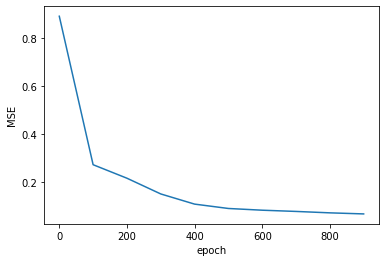

In [10]:
# build model
input_size = train_X.shape[1]
hidden_size = 10
output_size = 1
batch_size = 128
network = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size)
)

cost = torch.nn.MSELoss()
optimizer = torch.optim.SGD(network.parameters(), lr = 0.01)

# train
losses = []
for i in range(1000):
    batch_loss = []
    for start in range(0, len(X), batch_size):
        end = start + batch_size if start + batch_size < len(X) else len(X)
        x = Variable(torch.FloatTensor(X[start:end]))
        y = Variable(torch.FloatTensor(Y[start:end]))
        predict = network(x)
        loss = cost(predict, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())
    
    if i % 100 == 0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

plt.plot(np.arange(len(losses)) * 100, losses)
plt.xlabel('epoch')
plt.ylabel('MSE')

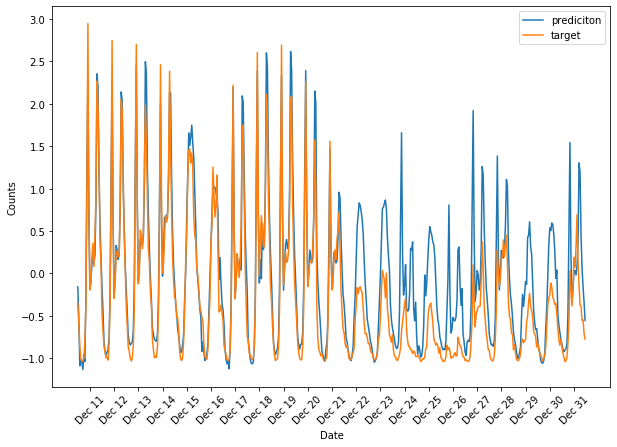

In [15]:
# test
targets = test_Y['cnt'].values
targets = targets.reshape(len(targets), 1)
targets = targets.astype(float)

x = Variable(torch.FloatTensor(test_X.values))
y = Variable(torch.FloatTensor(targets))

prediction = network(x)
prediction = prediction.data.numpy()

fig, ax = plt.subplots(figsize = (10, 7))
mean, std = scaled_features['cnt']
ax.plot(prediction * std + mean, label = 'prediciton')
ax.plot(targets * std + mean, label = 'target')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Counts')
dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24],rotation = 45)